# W200 Project 2
## Data analysis: Do different times of the year heat up evenly?

### 1. Introduction
This notebook explores the Northern Hemisphere Land and Sourther Hemisphere Land Data in an attemp to understand whether there are discrinable differences in how different months of the year are affected by global warming.  

In the project proposal, Global Land Data was used, but it was noted that given the differences in seasons between the two hemispheres, it will be better to use separate data for the two hemispheres.

In [4]:
# First, let's retrieve the data.  A small pythons script was prepared as usual to generate the following CSV files:
# (i) northern.csv: containing the time-based temperature anomaly and uncertainty data for norther hemisephere
# (ii)southern.csv: containing the time-based temperature anomaly and uncertainty data

from codes import webscraper_hemispheres

webscraper_hemispheres.generate_hemispheres_csv()
webscraper_hemispheres.generate_metadata_csv()

Handling northern hemisphere...
Handling southern hemisphere...


In [1]:
# For convenience, the data has also been placed into the data folders.  The following should help load the data from the files.
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

northern_data = pd.read_csv('data_files/northern.csv')
southern_data = pd.read_csv('data_files/southern.csv')
metadata = pd.read_csv('data_files/metadata_hemispheres.csv', index_col = 'Hemisphere')

### 2. Sanity checks
This part does some preliminary checks on data quality

In [9]:
# A. Checking the range and number of NaN values of various data sets
print('*' * 10 + "\nNorthern Hemisphere Data Sanity Check:\n" + '*' * 10)
for column in list(northern_data.columns):
    print(f"\nThe following is the key statistics of column {column}")
    print(f"Maximum value: {northern_data[column].max()}")
    print(f"Manimum value: {northern_data[column].min()}")
    print(f"Number of NaN values: {len(northern_data[northern_data[column].isna()])}")
    
# B. Checking the range of years and the number of months in each year
print(f"\nDoes each year in the data has all 12 months: {(northern_data['Year'].value_counts() == 12).all()}")

# C. Do the same for southern data:
print('*' * 10 + "\nSouthern Hemisphere Data Sanity Check:\n" + '*' * 10)
for column in list(southern_data.columns):
    print(f"\nThe following is the key statistics of column {column}")
    print(f"Maximum value: {southern_data[column].max()}")
    print(f"Manimum value: {southern_data[column].min()}")
    print(f"Number of NaN values: {len(southern_data[northern_data[column].isna()])}")
print(f"\nDoes each year in the data has all 12 months: {(southern_data['Year'].value_counts() == 12).all()}")


**********
Northern Hemisphere Data Sanity Check:
**********

The following is the key statistics of column Year
Maximum value: 2020
Manimum value: 1840
Number of NaN values: 0

The following is the key statistics of column Month
Maximum value: 12
Manimum value: 1
Number of NaN values: 0

The following is the key statistics of column Monthly_Anomaly
Maximum value: 2.883
Manimum value: -2.322
Number of NaN values: 1

The following is the key statistics of column Monthly_Uncertainty
Maximum value: 2.518
Manimum value: 0.042
Number of NaN values: 1

The following is the key statistics of column Annual_Anomaly
Maximum value: 1.789
Manimum value: -1.137
Number of NaN values: 8

The following is the key statistics of column Annual_Uncertainty
Maximum value: 0.628
Manimum value: 0.022
Number of NaN values: 8

The following is the key statistics of column Five_year_Anomaly
Maximum value: 1.5
Manimum value: -0.742
Number of NaN values: 44

The following is the key statistics of column Five_year

<ipython-input-9-39dfec0e810d>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Number of NaN values: {len(southern_data[northern_data[column].isna()])}")


Everything seems okay, except that:
(i) The Monthly_Anomaly Data for both hemispheres, which we will be using contains a NaN value, which may affect the range of years we use for the analysis
(ii) Not all years have all 12 months for the Southern Hemisphere Data.

Let's take a look at what the problem is:

In [16]:
# Checks the NaN entry for norther hemisphere first:
print(f"Northern hemisphere monthly data with NaN value:\n{northern_data[northern_data['Monthly_Anomaly'].isna()].iloc[: ,0:3]}")

# Then the southern hemisphere:
print(f"\nSouthern hemisphere monthly data with NaN value:\n{southern_data[southern_data['Monthly_Anomaly'].isna()].iloc[: ,0:3]}")

# Then the year with less than 12 months:
print(f"\nThe year with less than 12 months in record is:\n{southern_data.Year.value_counts()[southern_data.Year.value_counts() < 12]}")

Northern hemisphere monthly data with NaN value:
    Year  Month  Monthly_Anomaly
76  1846      5              NaN

Southern hemisphere monthly data with NaN value:
    Year  Month  Monthly_Anomaly
12  1881      8              NaN
13  1881      9              NaN

The year with less than 12 months in record is:
1880    5
Name: Year, dtype: int64


So to avoid complication and unless we wish to explore the data from earlier years, we may choose to do the analysis from 1881 and onwards.  For now, let's use 1900.

### 3. Defining the seasons
To investigate the different heating patterns across the year, it is suggested that instead of looking at each of the 12 months individually, we consider the 4 seasons.  Using the months individually do not look like a good idea given that the differences from year to year could easily lead to noise that make trend observation difficult.

But first, how do we define the seasons?  One way to do it is to use the definition of meterological seasons (for example, see: https://www.ncei.noaa.gov/news/meteorological-versus-astronomical-seasons), which means:

- Winter: Dec - Feb for Northern Hemisphere, and Jun - Aug for Southern Hemisphere
- Spring: Mar - May for Northern Hemisphere, and Sep - Nov for Southern Hemisphere
- Summer: Jun - Aug for Northern Hemisphere, and Dec - Jan for Southern Hemisphere
- Fall: Sep - Nov for Northern Hemisphere, and Mar - May for Southern Hemisphere

But does the above fit our data?  Are the winter months defined above truly the coldest months for both hemispheres?  And how about summer?

In [17]:
# The idea here is to look at the metadata for each hemisphere,
# then look at the average 1951-1980 temperature provided in the text file and
# extracted to the CSV, then rank them.  The 3 months with highest temp should
# be summer months, lowest 3 should be winter and so on.

# a subset of the metadata with only the northern hemisphere data points along
# with the monthly average temperature from 1951-1980
northern_metadata = metadata.iloc[0:1, 2:25:2].T
print("\nThe monthly average temperatures for northern hemisphere sorted in "
      + f"ascending order is:\n{northern_metadata.sort_values(by='northern')}")
southern_metadata = metadata.iloc[1:, 2:25:2].T
print("\nThe monthly average temperatures for southern hemisphere sorted in "
      + f"ascending order is:\n{southern_metadata.sort_values(by='southern')}")


The monthly average temperatures for northern hemisphere sorted in ascending order is:
Hemisphere  northern
Jan_temp       -2.06
Dec_temp       -0.38
Feb_temp       -0.04
Nov_temp        4.52
Mar_temp        4.57
Apr_temp       10.35
Oct_temp       10.99
May_temp       15.74
Sep_temp       16.63
Jun_temp       19.67
Aug_temp       20.21
Jul_temp       21.32

The monthly average temperatures for southern hemisphere sorted in ascending order is:
Hemisphere  southern
Jul_temp       12.34
Jun_temp       12.81
Aug_temp       13.50
May_temp       14.57
Sep_temp       15.48
Apr_temp       16.60
Oct_temp       17.41
Mar_temp       18.76
Nov_temp       19.30
Feb_temp       20.10
Dec_temp       20.44
Jan_temp       20.81


The above clearly fits the meterological definition and it should be fine to use that for this analysis.  Also, it is observed that the southern hemisphere temperatures are in general much higher than the northern ones.  Based on the current data alone, it is not clear whether this is due to sampling (e.g. most data points in the southern hemisphere are closer to the equator).

### 4. Adding a season column and preparing the 10-year averages for graph plotting
The next step is to actually add a data field to the Data Frames to set out the seasons, and then prepare the season-based temperature rise figures for visualization.

Here it is noted that only monthly anomaly data from Berkeley Earth can be used, because the other data are all averages already.  For instance, the annual anomaly for June 1990 is in fact the average of the 12 monthly anomaly data points from Jan 1990 to Dec 1990, so using data other than monthly anomaly will make it impossible to see the trend for each montn/season of the year.

However, just using the monthly anomaly data points will contain too much noise.  Following the general methodology used by Berkeley Earth which mainly uses 10-year anomaly averages for analysis, it is suggested that for the current analysis, we should use 10-year running averages of monthly anomaly data.

For example, the data for Spring 1990 should cover data from of Spring of 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994 and 1995, which means the average of the Mar, Apr and May data for the above years in the case of the Northern Hemisphere, and of Sep, Oct and Nov for the Southern Hemisphere.

In [2]:
# Treats the northern hemisphere data first:
northern_data['Season'] = 'Spring'
northern_data.loc[(northern_data.Month == 12) | (northern_data.Month <= 2), 'Season'] = 'Winter'
northern_data.loc[(northern_data.Month >= 6) & (northern_data.Month <= 8), 'Season'] = 'Summer'
northern_data.loc[(northern_data.Month >= 9) & (northern_data.Month <= 11), 'Season'] = 'Fall'

# Then the southern hemisephere data:   
southern_data['Season'] = 'Fall'
southern_data.loc[(southern_data.Month == 12) | (southern_data.Month <= 2), 'Season'] = 'Summer'
southern_data.loc[(southern_data.Month >= 6) & (southern_data.Month <= 8), 'Season'] = 'Winter'
southern_data.loc[(southern_data.Month >= 9) & (southern_data.Month <= 11), 'Season'] = 'Spring'

# Compiling a 10-year moving average by season
seasonal_data = {'northern': {'Spring': [],
                              'Summer': [],
                              'Fall': [],
                              'Winter': []},
                 'southern': {'Spring': [],
                              'Summer': [],
                              'Fall': [],
                              'Winter': []}}

for key in ('northern', 'southern'):
    
    hemis_data = northern_data if key == 'northern' else southern_data
    
    for season in seasonal_data[key]:
        
        data = hemis_data[hemis_data.Season == season] \
               .groupby('Year').mean() \
               .rolling(10, center=True).mean() \
               .Monthly_Anomaly.dropna().reset_index()
        
        # When calculating averages over an even-numbered period, Berkeley Earth puts
        # the label at the smaller number (e.g. as the 5th data point not the 6th for
        # a 10-year period).
        # This is different from the way rolling is done, which takes the larger value.
        data.Year = data.Year - 1       
        seasonal_data[key][season] = data

### 5. Plotting the data
The following shows two graphs, one each for the two hemispheres.

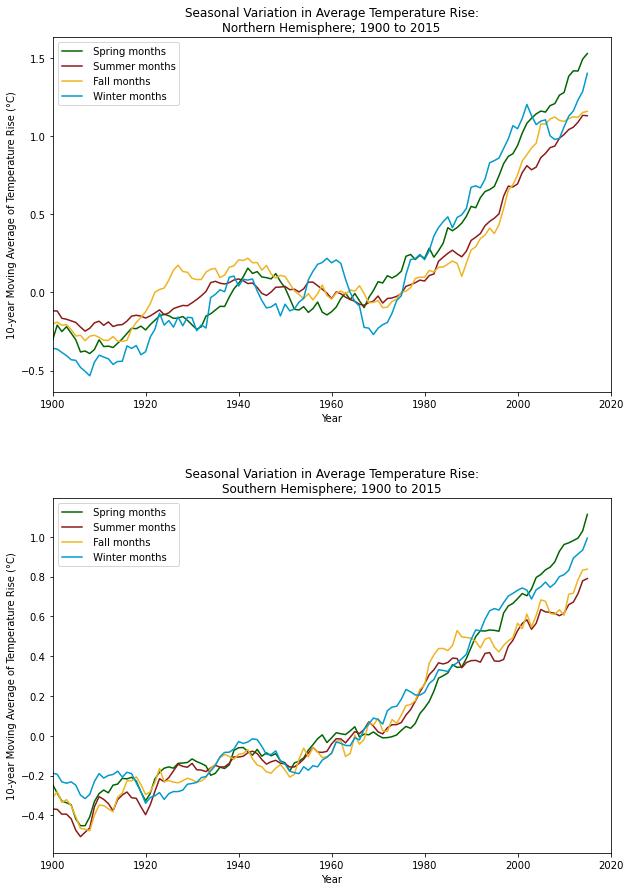

In [20]:
# A color dictionary for plotting
season_colors = {'Spring': "#006400",
                  'Summer': "#8B1A1A",
                  'Fall': "#EEB422",
                  'Winter': "#009ACD"}

fig, ax = plt.subplots(2, 1, figsize = (10, 15))
plt.subplots_adjust(hspace = 0.3)

for key in ('northern', 'southern'):
    
    axes = ax[0] if key == 'northern' else ax[1]
    
    for season in seasonal_data[key]:
        sns.lineplot(data = seasonal_data[key][season][seasonal_data[key][season].Year >= 1900], 
                     x = 'Year',
                     y = 'Monthly_Anomaly',
                     ax = axes,
                     color = season_colors[season],
                     label=f" {season} months",
                     legend = 'auto')
    axes.set_title(f"Seasonal Variation in Average Temperature Rise:\n{key.capitalize()} Hemisphere; 1900 to 2015")
    axes.set_xlabel("Year")
    axes.set_xlim(1900, 2020)
    axes.set_ylabel("10-year Moving Average of Temperature Rise (\N{DEGREE SIGN}C)")

### 6. Discussion
Some observations from the above:
- There is quite a visible difference between the different seasons, especially during the time when global warming picked up (in around 1980s, vide Nan's analysis on the global warming trend).  During this period, Winter and Spring show a markely large increase in temperature for both hemispheres.
- For the southern hemisphere, the warming trend seems to be remain relatively stable throughout the 20th century.  However, there is visiable change in pace for the northern hemisphere since around the 1980s.  Is this because the data points in the southern hemisphere are mainly in the tropics or sub-tropics (which is possibly shown in the average baseline temperature we looked at when defining the seasons)?  Or is there another underlying trend?  We will explore further into this when looking at city-based geographical data.